**In this Notebook, We shall perform crime forecasting for various use cases using Facebook Prophet library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

import os 
os.chdir('/content/drive/MyDrive/programs/Datasets/Los Angles Crime data')

In [2]:
cols = ['Date Occurred','Victim Sex','Victim Descent','Victim Age','AREA NAME','Crime Code Description','AREA NAME']   # we will only load these columns 
data1 = pd.read_csv('data/crimes_2010_2019.csv', usecols=cols)
data2 = pd.read_csv('data/crimes_2020_2021.csv', usecols=cols)
dataset = pd.concat([data1,data2])
print('shape: ', dataset.shape)

shape:  (2437912, 6)


In [3]:
dataset = dataset.sort_values('Date Occurred').reset_index(drop=True)
dataset

Date Occurred    AREA NAME  ... Victim Sex  Victim Descent
0          2010-01-01  N Hollywood  ...          M               W
1          2010-01-01     Van Nuys  ...          F               O
2          2010-01-01  N Hollywood  ...          F               W
3          2010-01-01     Van Nuys  ...          F               W
4          2010-01-01  N Hollywood  ...          M               W
...               ...          ...  ...        ...             ...
2437907    2021-08-23      West LA  ...          M               W
2437908    2021-08-23  West Valley  ...          F               H
2437909    2021-08-23  77th Street  ...          M               B
2437910    2021-08-23  77th Street  ...          F               B
2437911    2021-08-23    Southeast  ...          F               H

[2437912 rows x 6 columns]

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2437912 entries, 0 to 2437911
Data columns (total 6 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Date Occurred           object
 1   AREA NAME               object
 2   Crime Code Description  object
 3   Victim Age              int64 
 4   Victim Sex              object
 5   Victim Descent          object
dtypes: int64(1), object(5)
memory usage: 111.6+ MB


In [5]:
# classifying ge into various age groups

def classifyAge(age):
  if age in range(0,15):
    return "Children"
  elif age in range(15,25):
    return "Youths"
  elif age in range(25,65):
    return "Adults"
  elif age > 64:
    return "Seniors"
  else:
    "Invalid"
data = dataset.copy()
data['Age Group'] = data['Victim Age'].apply(lambda x : classifyAge(x))

In [6]:
import datetime as dt
data['Date Occurred'] = pd.to_datetime(data['Date Occurred'])
data['Occ_M/Y'] = data['Date Occurred'].dt.to_period('m')

# 1. Forecasting Crrimes Rates
We eill use Prophet library by Facebook for forecasting crimes rate.


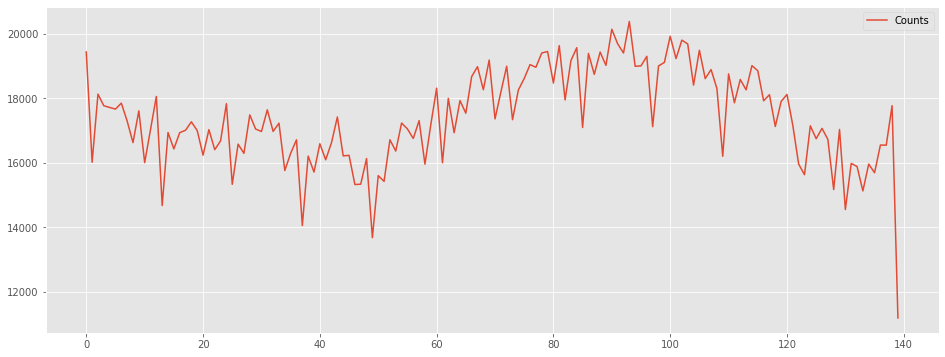

In [ ]:
# lets first visualize 
data.groupby('Occ_M/Y').size().reset_index(name='Counts').plot(figsize=(16,6))

In [ ]:
# Prophet is an univariate time series analysis model.
df = data.groupby('Occ_M/Y').size().reset_index(name='count')
df

Occ_M/Y  count
0    2010-01  19433
1    2010-02  16016
2    2010-03  18125
3    2010-04  17767
4    2010-05  17713
..       ...    ...
135  2021-04  15691
136  2021-05  16548
137  2021-06  16546
138  2021-07  17769
139  2021-08  11191

[140 rows x 2 columns]

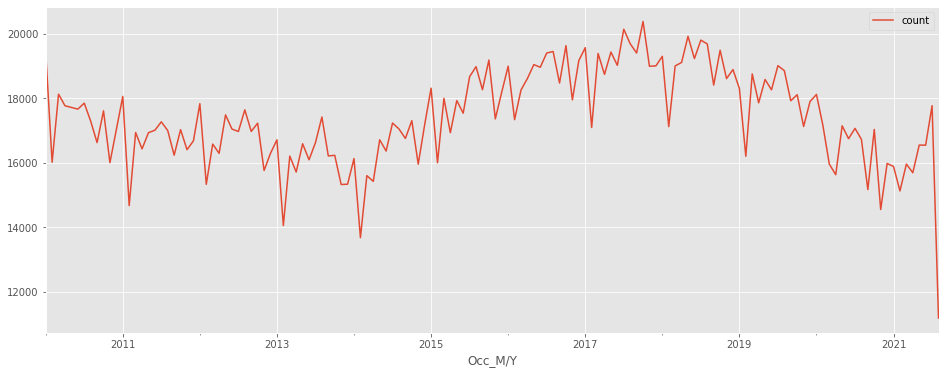

In [ ]:
# code in this cell is just for visualization purpose only
df1 = df.copy()
df1.index = df1['Occ_M/Y']
df1.drop('Occ_M/Y',axis=1,inplace=True)
df1.plot(figsize=(16,6))

we can see a sharp drop at extreme rigt handside of the plot above.This is because we don't have data for whole month there(only upto day 23 still 7 days data missing). So either we use only whole months on our analysis or rescale this last month depending on the number of days we have accounted for it.  
i have dropped this last month (2021-08) for analysis.(nothing seems odd even if we use that incomplete last month data)

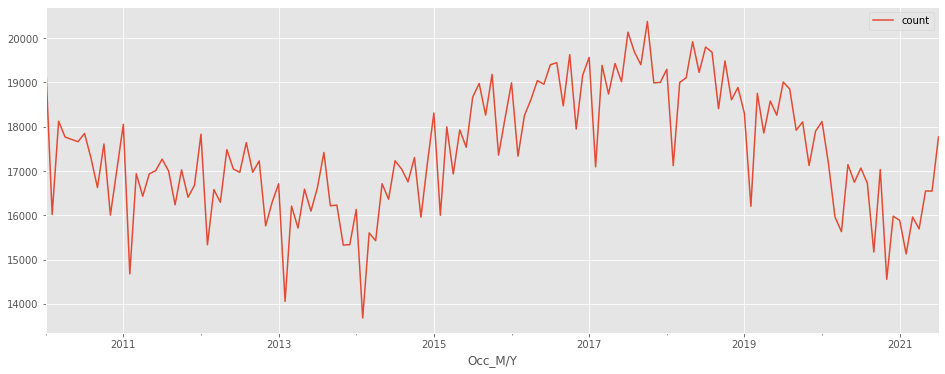

In [ ]:
# lets drop the last month i.e 2021-08 from our data because it doesnot have data for whole months thus sharp drop as seen above.
df.drop(df[df['Occ_M/Y']=='2021-08'].index, axis=0, inplace=True)
df1 = df.copy()
df1.index = df1['Occ_M/Y']
df1.drop('Occ_M/Y',axis=1,inplace=True)
df1.plot(figsize=(16,6))

There is sharp drop anymore now because we have removed that incomplete month data.

### Evaluating Model

In [ ]:
train_data = df.rename(columns={'Occ_M/Y':'ds', 'count':'y'})         # renaming columns name that Prohet requires
train_data['ds'] = pd.to_datetime(train_data['ds'].astype(str))        # change period to datetime
train_data

ds      y
0   2010-01-01  19433
1   2010-02-01  16016
2   2010-03-01  18125
3   2010-04-01  17767
4   2010-05-01  17713
..         ...    ...
134 2021-03-01  15960
135 2021-04-01  15691
136 2021-05-01  16548
137 2021-06-01  16546
138 2021-07-01  17769

[139 rows x 2 columns]

In [ ]:
model = Prophet()
model.fit(train_data)             ## model training

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=120)     # creating future dataset with the help of Prophet so that we make prediction on unseen data.
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0   2010-01-01  18111.057795  17504.603795  18697.091456
1   2010-02-01  15816.598285  15236.323707  16410.952360
2   2010-03-01  17441.723170  16835.205444  18076.987059
3   2010-04-01  16987.767058  16378.470305  17590.093534
4   2010-05-01  17765.279742  17158.570086  18351.790156
..         ...           ...           ...           ...
254 2021-10-25  16034.268567  15452.677522  16698.552033
255 2021-10-26  15792.697303  15242.093255  16396.424315
256 2021-10-27  15559.979043  15010.446658  16197.599044
257 2021-10-28  15337.371272  14768.359961  15980.953195
258 2021-10-29  15125.647433  14495.315387  15699.153336

[259 rows x 4 columns]

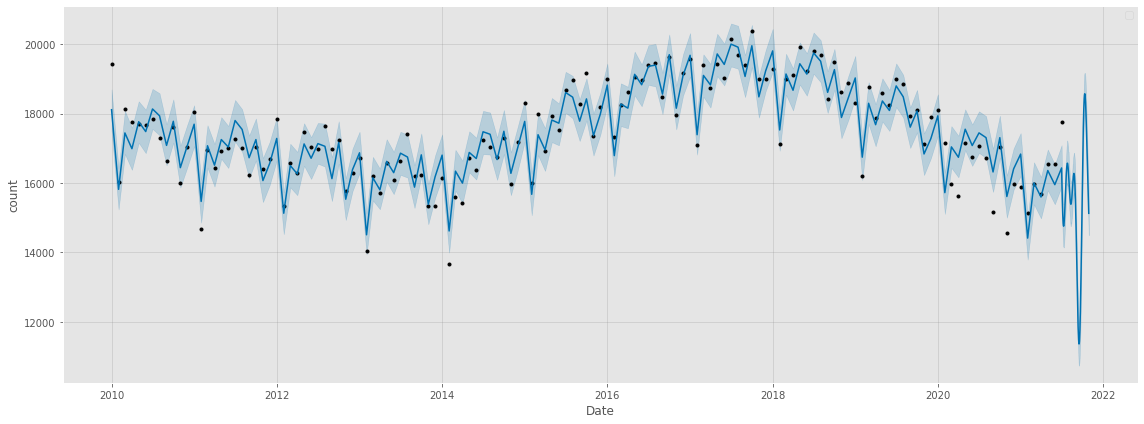

In [ ]:
figure = model.plot(forecast, xlabel='Date', ylabel='count', figsize=(16,6))
plt.legend()

The dotted line represent the actual data points we used in the training. The line represent the prediction made. Also we can see the predictions made on the unseen data we created with only lines(no dots) at the extreme right hand side.

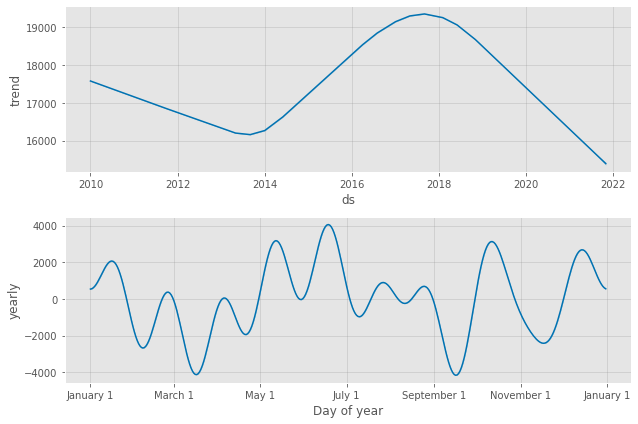

In [ ]:
figure2 = model.plot_components(forecast)

### Error Analysis

It is critical to develop an objective estimate of a forecast model’s performance. We shall do error analysis for the forecast we made above in this section.

In [21]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
# Lets first use Mean Absolute Error(MAE)
from sklearn.metrics import mean_absolute_error
actual = df['count']
pred = forecast.iloc[:139,[0,-1]].yhat
mae = mean_absolute_error(actual, pred)
print('MAE: %.3f' % mae)
print('RMSE score:',rmse(pred,actual))
print('SMAPE score: ', smape(pred,actual))

MAE: 364.327
RMSE score: 471.49855757117905
SMAPE score:  2.131982339148772


MAE stands for Mean Absolute Error, thus if yours is 364.327 it means, that if you randomly choose a data point from your data, then, you would expect your prediction to be 364.327 away from the true value. Is it good? Bad? Depends on the scale of your output. Since our output data are in scale of thousands, our MAE score can be considered good.    

Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors. Generally, the lower the smape score, better the forecast but we need to consider the data too. For more about SMAPE see <a href='https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error'>this</a>.



See the plot below and generalize what i just mentioned above.

the pattern of predicted values almost follows the pattern of true value(acutal value). This is what we have expecting.

In [ ]:
error = pd.DataFrame({
    'date':train_data.ds,
    'actual':list(actual),
    'pred':list(pred)
})
error['error'] = np.abs(error.actual - error.pred)
error

date  actual          pred        error
0   2010-01-01   19433  18111.057795  1321.942205
1   2010-02-01   16016  15816.598285   199.401715
2   2010-03-01   18125  17441.723170   683.276830
3   2010-04-01   17767  16987.767058   779.232942
4   2010-05-01   17713  17765.279742    52.279742
..         ...     ...           ...          ...
134 2021-03-01   15960  16000.605843    40.605843
135 2021-04-01   15691  15595.514473    95.485527
136 2021-05-01   16548  16359.178226   188.821774
137 2021-06-01   16546  15951.634366   594.365634
138 2021-07-01   17769  16432.977571  1336.022429

[139 rows x 4 columns]

In [ ]:
error[['actual','pred','error']].describe().T

count         mean  ...           75%           max
actual  139.0  17458.42446  ...  18609.000000  20378.000000
pred    139.0  17458.20303  ...  18392.447775  20000.472926
error   139.0    364.32683  ...    519.916838   1437.627694

[3 rows x 8 columns]

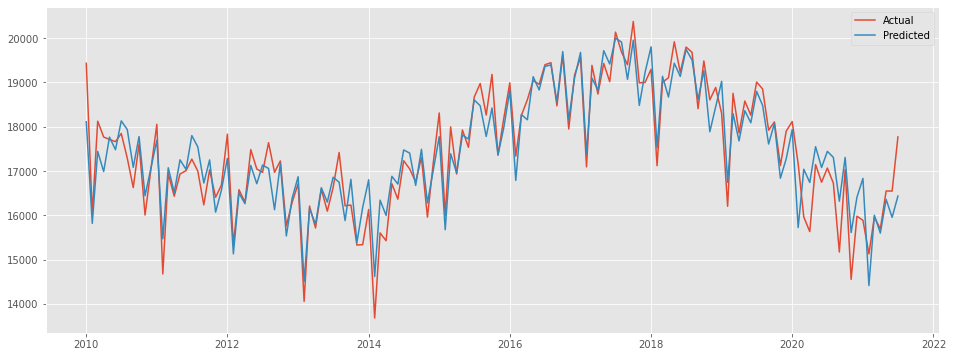

In [ ]:
#plot actual vs predicted values. If you are confused with plot above using prophet's inbuilt plot function, below figure will clear that confusion
# Note: i havenot shown future forecast here.
plt.figure(figsize=(16,6))
labels = list(error.date)
plt.plot(labels,actual, label='Actual')
plt.plot(labels,pred, label='Predicted')
plt.legend()
plt.show()

# 2. Forecasting Crimes Incidents/Rate/Counts based on Age Group
Prophet library by Facebook is used for forecasting/prediction

In [ ]:
agegrp = data.groupby(['Occ_M/Y','Age Group']).size().reset_index(name='count')
agegrp

Occ_M/Y Age Group  count
0    2010-01    Adults  11249
1    2010-01  Children   4091
2    2010-01   Seniors    951
3    2010-01    Youths   3129
4    2010-02    Adults   9227
..       ...       ...    ...
555  2021-07    Youths   2013
556  2021-08    Adults   6402
557  2021-08  Children   2869
558  2021-08   Seniors    588
559  2021-08    Youths   1332

[560 rows x 3 columns]

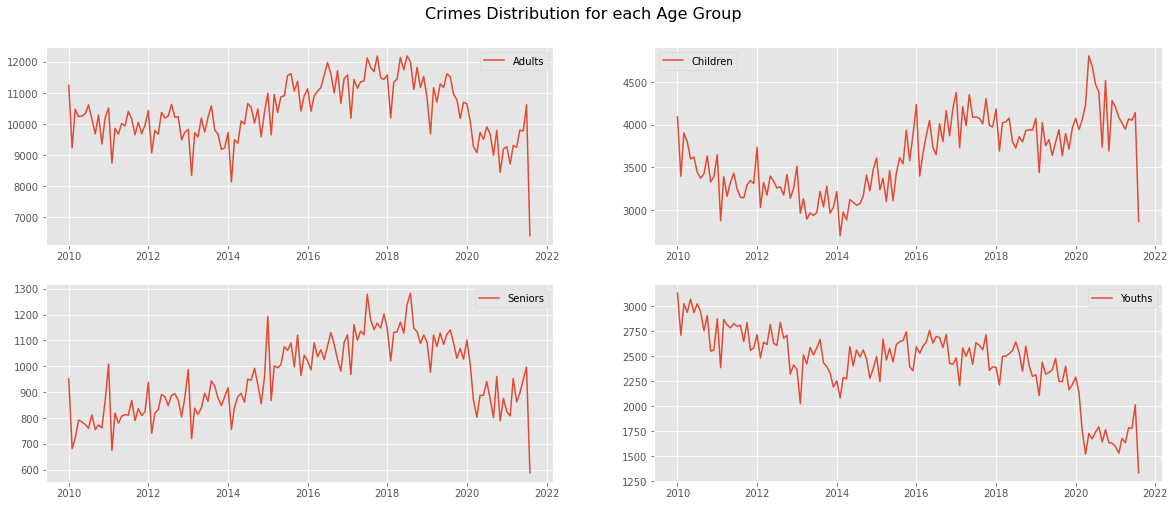

In [ ]:
plt.figure(figsize=(20,8))
count = 1
plt.suptitle('Crimes Distribution for each Age Group ', fontsize=16, y=0.95)
for i in list(agegrp['Age Group'].unique()):
  plt.subplot(2, 2, count)
  df = agegrp[agegrp['Age Group']==i][['Occ_M/Y','count']].reset_index(drop=True)
  dates = pd.to_datetime(df['Occ_M/Y'].astype(str))   # convert perioed to string/object first and than to datetime
  values = df['count']
  plt.plot(dates,values, label=i)
  plt.legend()
  count += 1
plt.show()

### Evaluating Model

In [ ]:
train_data = agegrp.rename(columns={'Occ_M/Y':'ds', 'count':'y'})         # renaming columns name that Prohet requires
train_data['ds'] = pd.to_datetime(train_data['ds'].astype(str))        # change period to datetime
train_data

ds Age Group      y
0   2010-01-01    Adults  11249
1   2010-01-01  Children   4091
2   2010-01-01   Seniors    951
3   2010-01-01    Youths   3129
4   2010-02-01    Adults   9227
..         ...       ...    ...
555 2021-07-01    Youths   2013
556 2021-08-01    Adults   6402
557 2021-08-01  Children   2869
558 2021-08-01   Seniors    588
559 2021-08-01    Youths   1332

[560 rows x 3 columns]

In [ ]:
def Predictions(agegroup):
  model = Prophet(weekly_seasonality=True)
  train = train_data[train_data['Age Group'] == agegroup]
  model.fit(train)
  future = model.make_future_dataframe(periods=90)
  forecast = model.predict(future)
  figure = model.plot(forecast, xlabel='Date', ylabel='count', figsize=(14,4))
  ax = figure.gca()
  ax.set_title("Predicting and Forecasting Crime Incidents for "+i, size=16)
  print('\n\n')
  return forecast


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


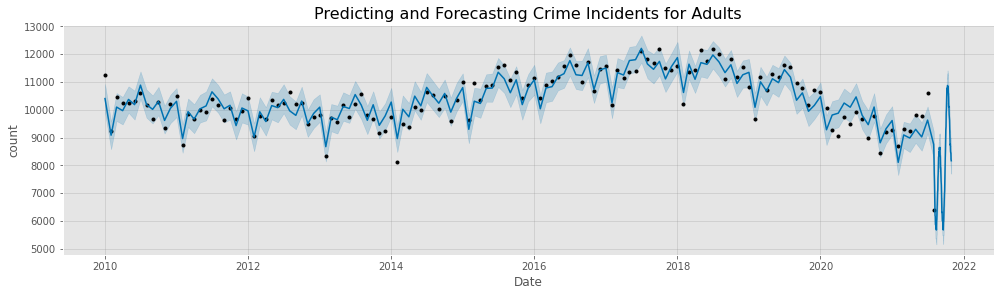

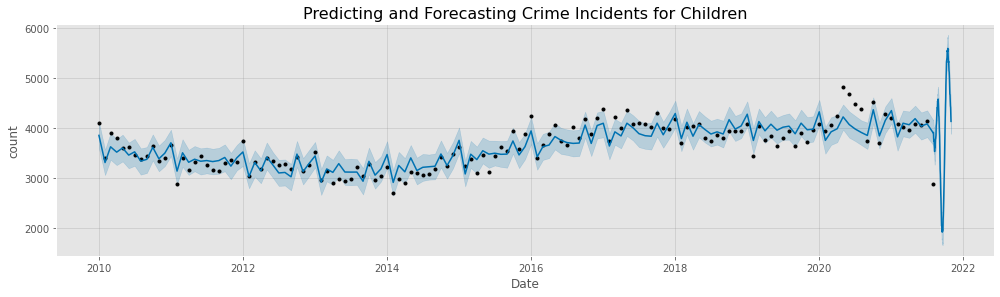

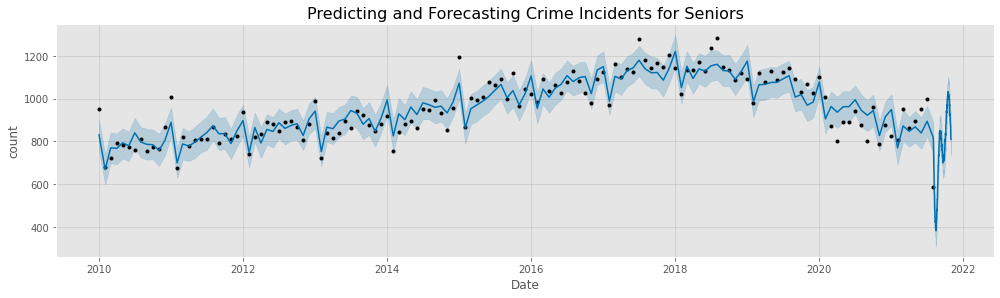

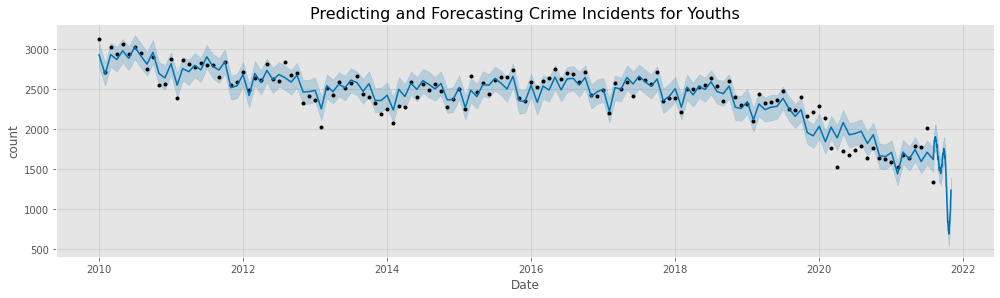

In [ ]:
Forecast = {}
for i in list(agegrp['Age Group'].unique()):
  result = Predictions(i)
  Forecast[i] = result

### Error Analysis
Like in the section 1 above, we shall analyze error here too exactly in similiaar manaer.

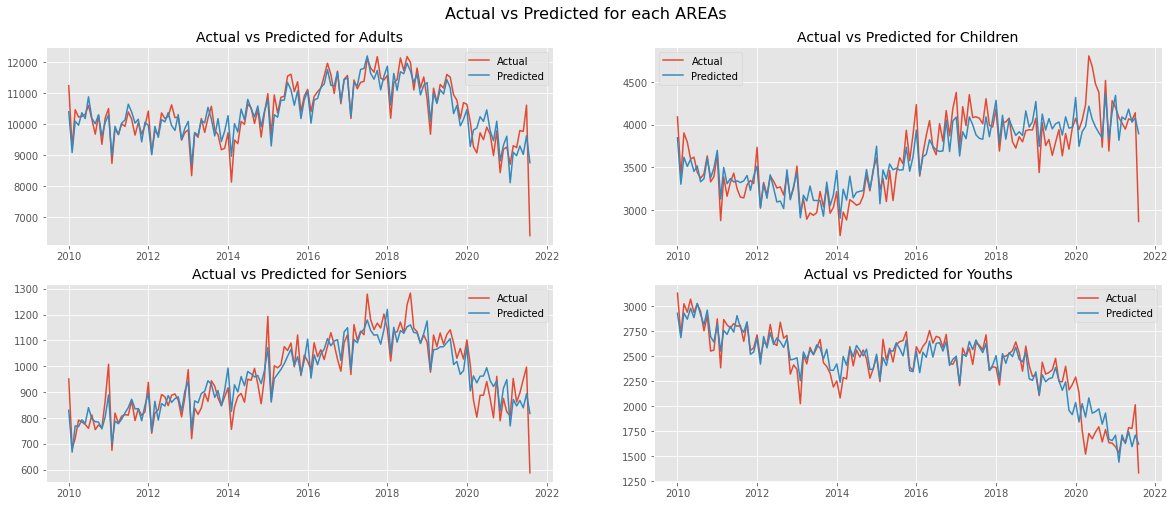

In [ ]:
MAE_Score = {}
RMSE_score ={}
SMAPE_score = {}
count = 1
plt.figure(figsize=(20,8))
plt.suptitle('Actual vs Predicted for each AREAs', fontsize=16,y=0.95)
for i in list(agegrp['Age Group'].unique()):
  plt.subplot(2,2,count)
  df1 = train_data[train_data['Age Group']==i] .reset_index(drop=True)
  actual = df1['y']
  date =  list(df1.ds)
  index = df1.shape[0]
  df2 = Forecast[i]
  pred = df2.iloc[:index,-1]
  mae = mean_absolute_error(actual,pred)
  MAE_Score[i] = mae
  RMSE_score[i] = rmse(pred,actual)
  SMAPE_score[i] = smape(pred,actual)
  plt.plot(date,actual, label='Actual')
  plt.plot(date,pred, label='Predicted')
  plt.title('Actual vs Predicted for '+i, fontsize=14)
  plt.legend()
  count += 1
plt.show()


In [ ]:
MAE_Score

{'Adults': 290.96726658001967,
 'Children': 157.60069452352585,
 'Seniors': 43.27280347703064,
 'Youths': 90.44030247966516}

In [ ]:
RMSE_score

{'Adults': 394.01933399071635,
 'Children': 205.222927636983,
 'Seniors': 56.170780993609014,
 'Youths': 119.35251972502603}

In [ ]:
SMAPE_score

{'Adults': 2.9053078043717764,
 'Children': 4.304865130529026,
 'Seniors': 4.588100410582217,
 'Youths': 4.042567596817319}

# 3. Crime Forecasting/Predction for different Areas of the City
In this section we shall perform crime forecasting for different areas of the city.

In [ ]:
area = data.groupby(['Occ_M/Y','AREA NAME']).size().reset_index(name='count')
area

Occ_M/Y    AREA NAME  count
0     2010-01  77th Street   1284
1     2010-01      Central    613
2     2010-01   Devonshire    976
3     2010-01     Foothill    958
4     2010-01       Harbor    886
...       ...          ...    ...
2935  2021-08      Topanga    429
2936  2021-08     Van Nuys    478
2937  2021-08      West LA    483
2938  2021-08  West Valley    456
2939  2021-08     Wilshire    458

[2940 rows x 3 columns]

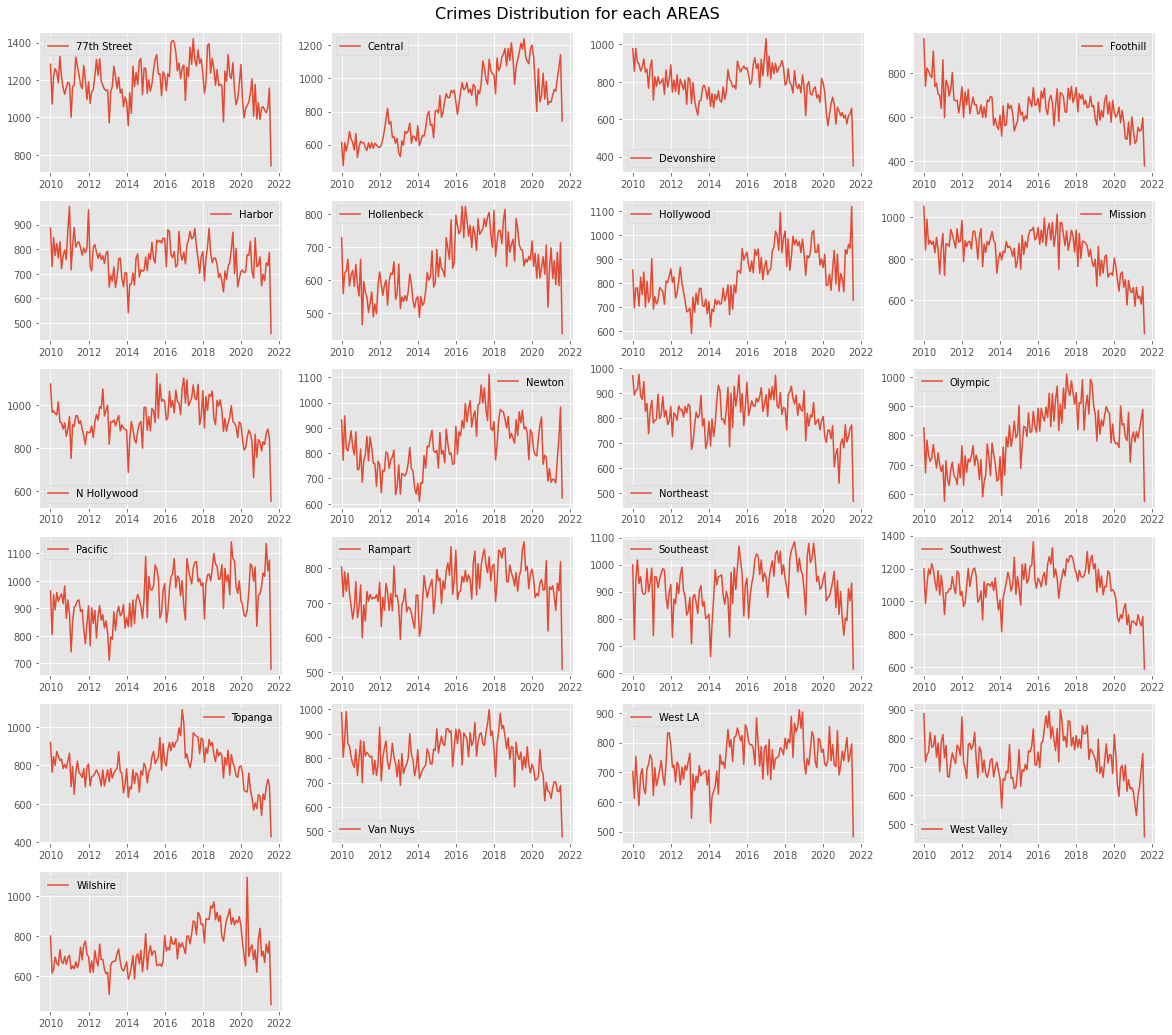

In [ ]:
plt.figure(figsize=(20,18))
count = 1
plt.suptitle('Crimes Distribution for each AREAS ', fontsize=16, y=0.90)
for i in list(area['AREA NAME'].unique()):
  plt.subplot(6, 4, count)
  df = area[area['AREA NAME']==i][['Occ_M/Y','count']].reset_index(drop=True)
  dates = pd.to_datetime(df['Occ_M/Y'].astype(str))   # convert perioed to string/object first and than to datetime
  values = df['count']
  plt.plot(dates,values, label=i)
  plt.legend()
  count += 1
plt.show()

### Evaluating Model

In [ ]:
train_data = area.rename(columns={'Occ_M/Y':'ds', 'count':'y'})         # renaming columns name that Prohet requires
train_data['ds'] = pd.to_datetime(train_data['ds'].astype('str'))        # change period to datetime
train_data

ds    AREA NAME     y
0    2010-01-01  77th Street  1284
1    2010-01-01      Central   613
2    2010-01-01   Devonshire   976
3    2010-01-01     Foothill   958
4    2010-01-01       Harbor   886
...         ...          ...   ...
2935 2021-08-01      Topanga   429
2936 2021-08-01     Van Nuys   478
2937 2021-08-01      West LA   483
2938 2021-08-01  West Valley   456
2939 2021-08-01     Wilshire   458

[2940 rows x 3 columns]

In [ ]:
# train Prophet model
def Predictions(areaname):
  model = Prophet()
  train = train_data[train_data['AREA NAME'] == areaname]
  model.fit(train)
  future = model.make_future_dataframe(periods=90)
  forecast = model.predict(future)
  figure = model.plot(forecast, xlabel='Date', ylabel='count', figsize=(10,4))
  ax = figure.gca()
  ax.set_title("Predicting and Forecasting Crime Incidents for "+areaname, size=16)
  return forecast

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

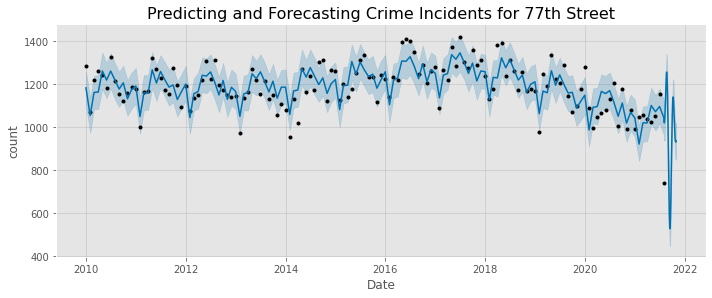

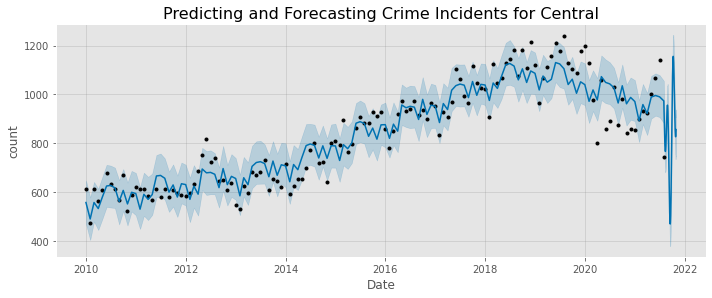

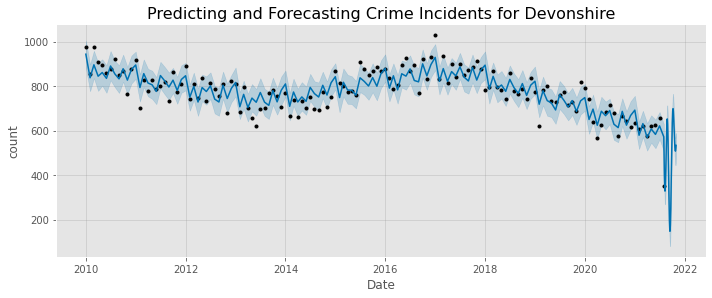

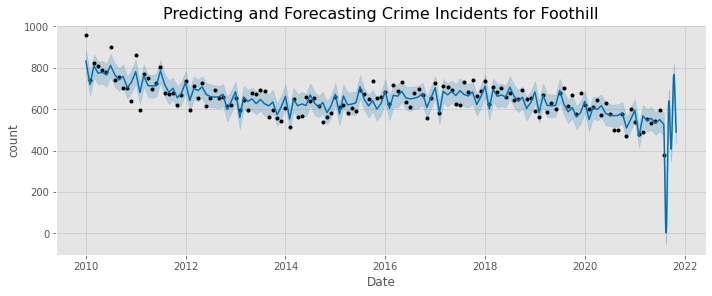

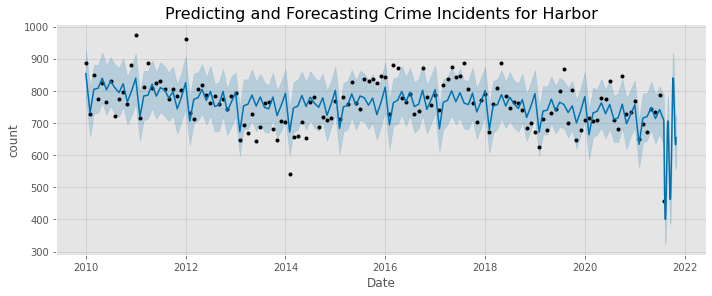

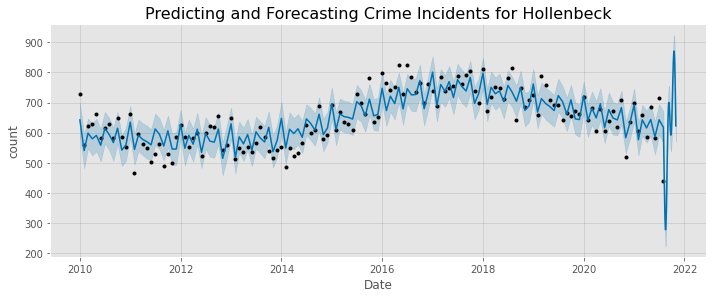

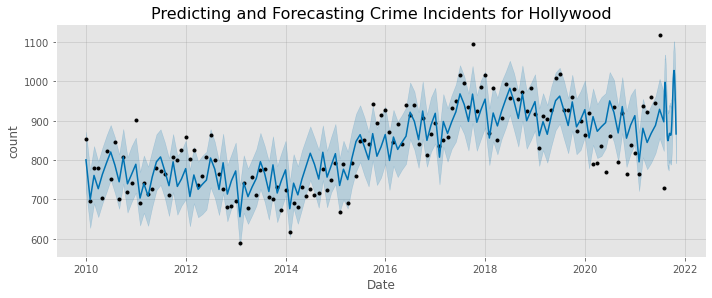

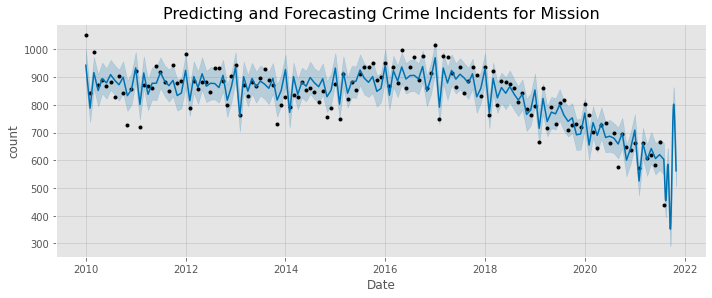

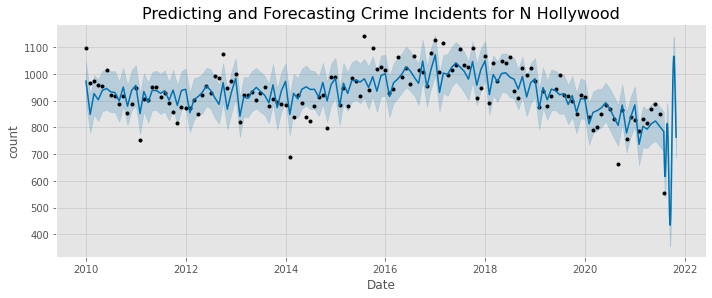

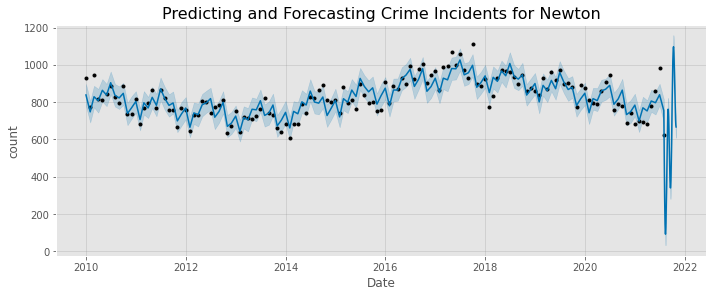

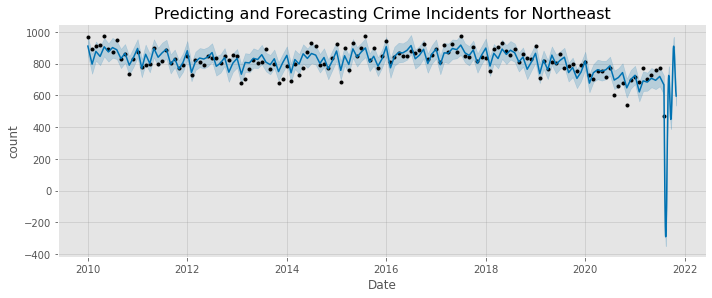

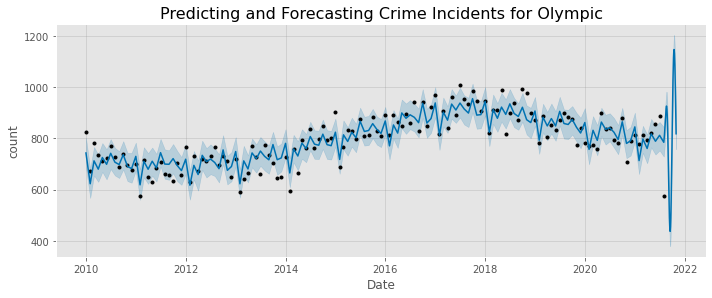

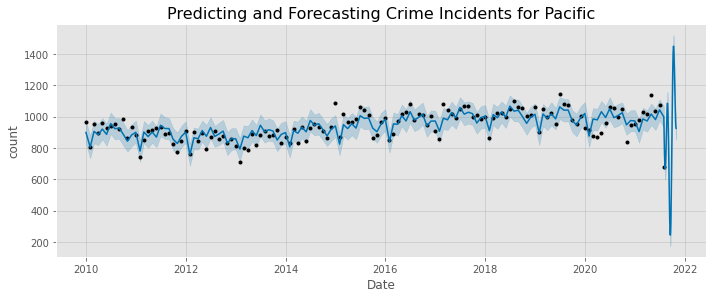

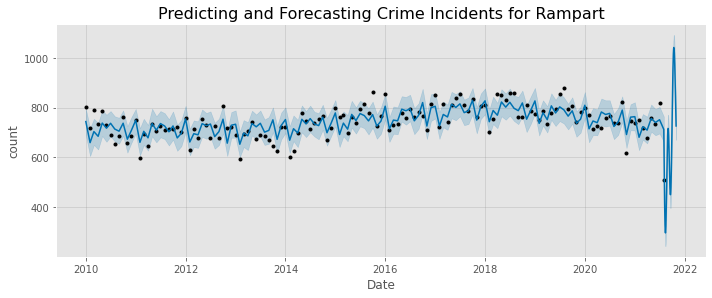

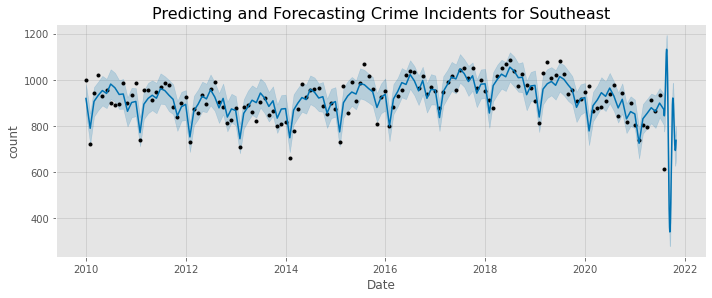

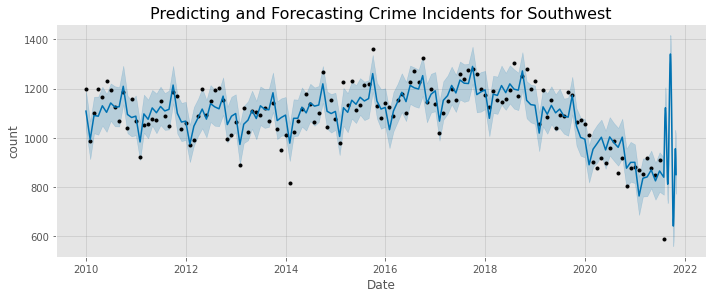

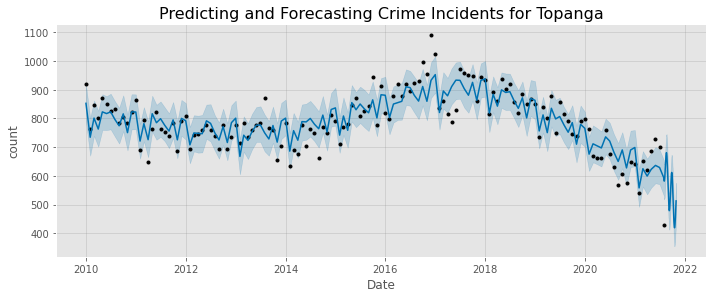

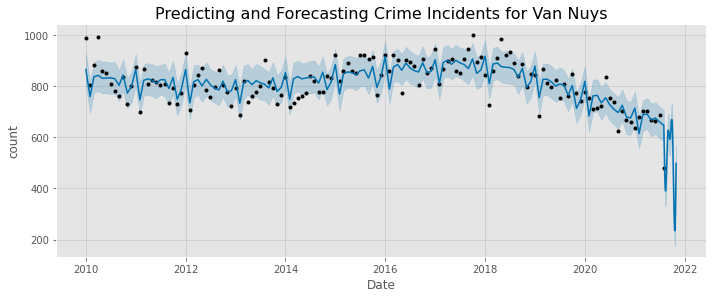

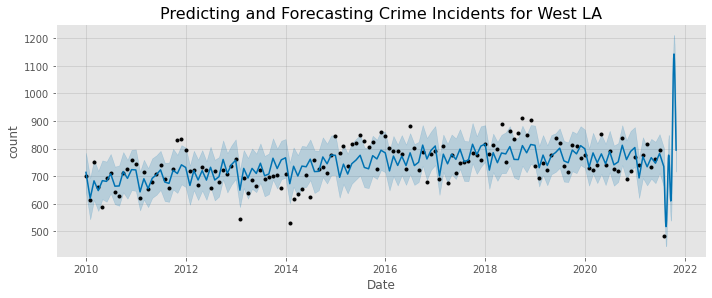

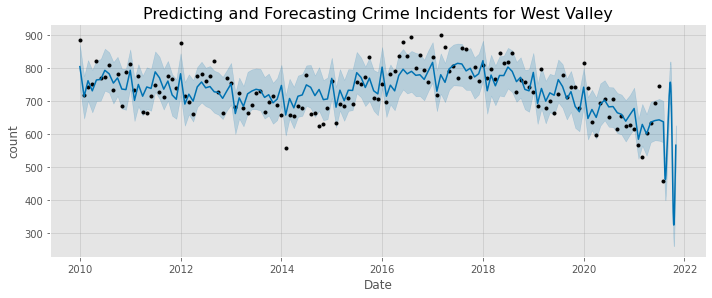

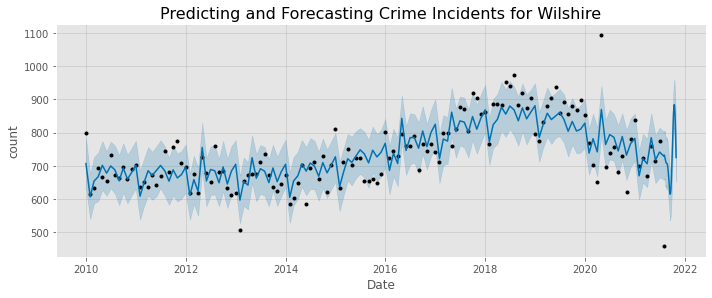

In [ ]:
Forecast = {}
for areaname in list(area['AREA NAME'].unique()):
  result = Predictions(areaname)
  Forecast[areaname] = result

### Error Analysis

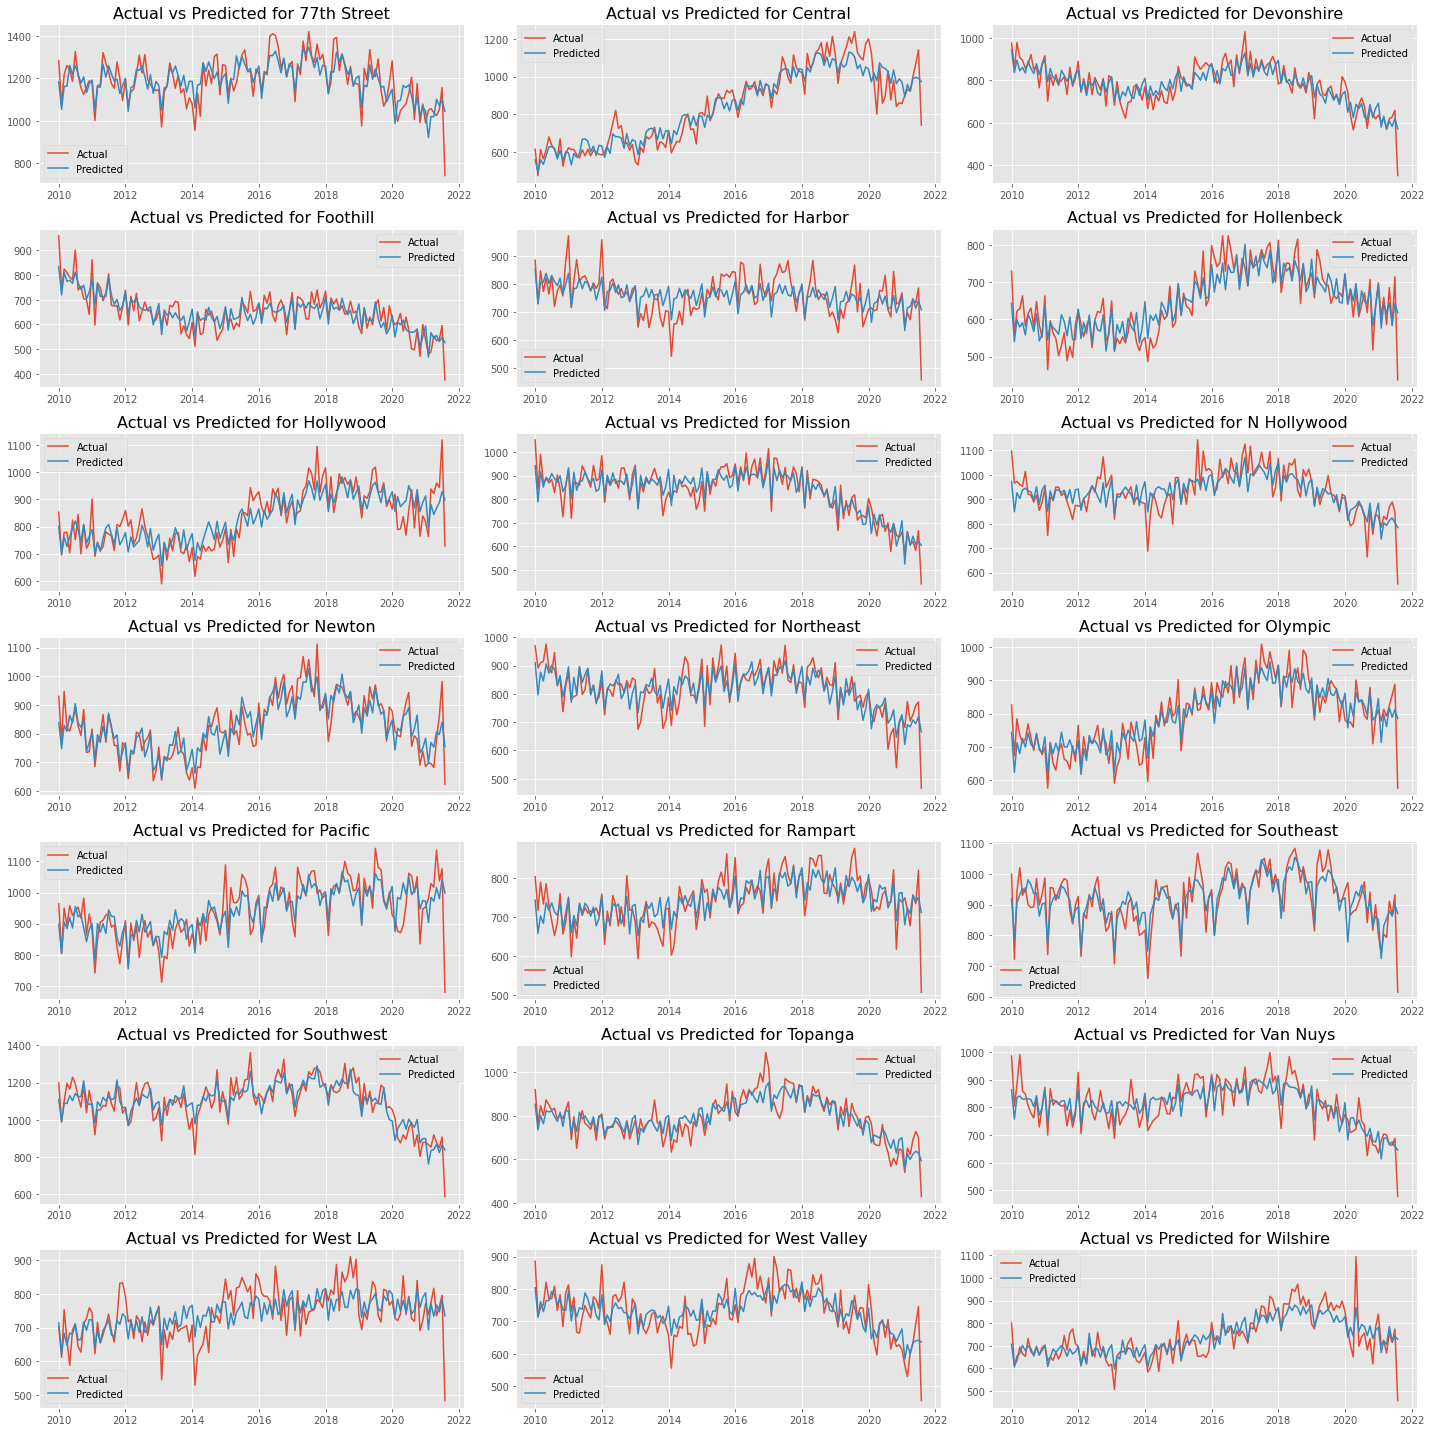

In [ ]:
MAE_Score = {}
RMSE_scores = {}
SMAPE_score= {}
count = 1
plt.figure(figsize=(20,20))
for i in list(area['AREA NAME'].unique()):
  plt.subplot(7,3,count)
  df1 = train_data[train_data['AREA NAME']==i] .reset_index(drop=True)
  actual = df1['y']
  date = list(df1.ds)
  df2 = Forecast[i]
  pred = df2.iloc[:index,-1]
  mae = mean_absolute_error(actual,pred)
  MAE_Score[i] = mae
  RMSE_score[i] = rmse(pred,actual)
  SMAPE_score[i] = smape(pred,actual)
  plt.plot(date,actual, label='Actual')
  plt.plot(date,pred, label='Predicted')
  plt.title('Actual vs Predicted for '+i, fontsize=16)
  plt.legend()
  count += 1
plt.tight_layout()
plt.show()

In [ ]:
MAE_Score

{'77th Street': 49.56718469243762,
 'Central': 51.45057995805034,
 'Devonshire': 37.06402491034421,
 'Foothill': 34.47721306428729,
 'Harbor': 44.9039275328656,
 'Hollenbeck': 32.69634086808518,
 'Hollywood': 45.479226035047645,
 'Mission': 34.67699816991386,
 'N Hollywood': 42.40205818030199,
 'Newton': 37.175978461540815,
 'Northeast': 36.010364412491384,
 'Olympic': 33.74950734767407,
 'Pacific': 39.61895593049448,
 'Rampart': 30.477257701142452,
 'Southeast': 36.71888835831515,
 'Southwest': 47.713635518019615,
 'Topanga': 38.16250185309729,
 'Van Nuys': 38.166442178312096,
 'West LA': 42.775512033584725,
 'West Valley': 38.587294699757514,
 'Wilshire': 41.04511317012476}

In [ ]:
RMSE_score

{'77th Street': 64.17653791781345,
 'Central': 67.16706342255486,
 'Devonshire': 48.24442976632258,
 'Foothill': 43.15770166356821,
 'Harbor': 58.600321848760416,
 'Hollenbeck': 42.47120778663021,
 'Hollywood': 56.14373071472517,
 'Mission': 43.89920337081785,
 'N Hollywood': 57.55698097956153,
 'Newton': 47.209023007978715,
 'Northeast': 46.24020118744776,
 'Olympic': 44.057641459072286,
 'Pacific': 54.5908943178778,
 'Rampart': 41.074854906394044,
 'Southeast': 49.505669761651994,
 'Southwest': 60.72322104900937,
 'Topanga': 48.708062862595796,
 'Van Nuys': 48.64529941430228,
 'West LA': 56.54583593298057,
 'West Valley': 48.51221360608554,
 'Wilshire': 56.1549830682278}

In [ ]:
SMAPE_score

{'77th Street': 4.259584437665083,
 'Central': 6.222696152930468,
 'Devonshire': 4.950102288936724,
 'Foothill': 5.430835854513614,
 'Harbor': 5.971460643574814,
 'Hollenbeck': 5.176393345389324,
 'Hollywood': 5.492183633025975,
 'Mission': 4.289215163453941,
 'N Hollywood': 4.649855919480546,
 'Newton': 4.530850503387501,
 'Northeast': 4.56984643148793,
 'Olympic': 4.338523024631454,
 'Pacific': 4.257753717859773,
 'Rampart': 4.164410527374753,
 'Southeast': 4.084835708214386,
 'Southwest': 4.519444746705509,
 'Topanga': 4.968680797429855,
 'Van Nuys': 4.768330826085452,
 'West LA': 5.814068854362574,
 'West Valley': 5.331498997848702,
 'Wilshire': 5.554030316230461}

okay..everything looks good.

# 4. Victim Descent Crime Forecasting
Here in this section, we will try to forecasting crimes incidents for victim descent.

In [10]:
Descent = {'A':'Other Asian', 'B':'Black', 'C':'Chinese', 'D':'Combodian','F':'Filipin0', 'G':'Guamanian',
           'H':'Hispanic/Latin/Mexican', 'I':'American Indian/Alaskan Native', 'J':'Japanese','K':'Korean',
           'L':'Laotian','O':'Other','P':'Pacific Islander', 'S':'Samoan', 'U':'Hawalian', 'V':'Vietnamses',
           'W':'White', 'X':'Unknown', 'Z':'Asian Indian', 'nan':'Nan'}

des = ['B', 'H', 'W', 'X', 'A', 'O', 'C', 'F', 'K', 'I', 'V', 'J','G', 'P', 'U', 'S', 'Z', 'D', 'L']
df = data.loc[data['Victim Descent'].isin(des)]
vict_descent = df.groupby(['Occ_M/Y', 'Victim Descent']) .size().reset_index(name='count').sort_values('Occ_M/Y')
vict_descent['Victim Descent'] = vict_descent['Victim Descent'].apply(lambda x: Descent[x])
vict_descent = vict_descent.reset_index(drop=True)
vict_descent

Occ_M/Y Victim Descent  count
0     2010-01    Other Asian    407
1     2010-01        Unknown    232
2     2010-01          White   4886
3     2010-01         Samoan      1
4     2010-01          Other   1777
...       ...            ...    ...
2096  2021-08          Black   1653
2097  2021-08    Other Asian    229
2098  2021-08        Unknown   1022
2099  2021-08       Japanese     15
2100  2021-08   Asian Indian      6

[2101 rows x 3 columns]

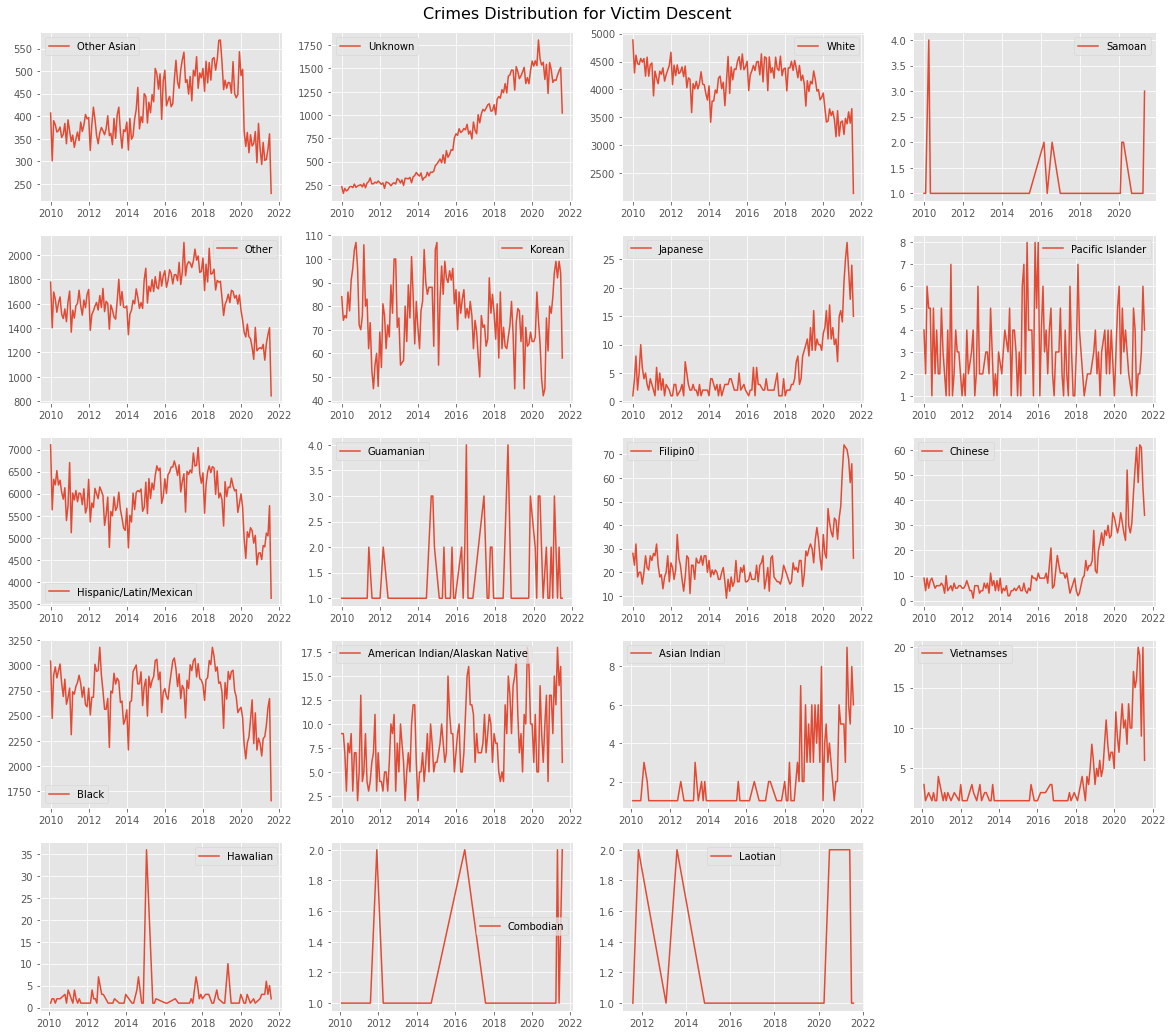

In [13]:
# How crimes incident is distributing over the years for victim descent?
plt.figure(figsize=(20,18))
count = 1
plt.suptitle('Crimes Distribution for Victim Descent ', fontsize=16, y=0.90)
for i in list(vict_descent['Victim Descent'].unique()):
  plt.subplot(5, 4, count)
  df = vict_descent[vict_descent['Victim Descent']==i][['Occ_M/Y','count']].reset_index(drop=True)
  dates = pd.to_datetime(df['Occ_M/Y'].astype(str))   # convert perioed to string/object first and than to datetime
  values = df['count']
  plt.plot(dates,values, label=i)
  plt.legend()
  count += 1
plt.show()

### Evaluating Model
Now using Prophet to forecast

In [14]:
train_data = vict_descent.rename(columns={'Occ_M/Y':'ds', 'count':'y'})         # renaming columns name that Prohet requires
train_data['ds'] = pd.to_datetime(train_data['ds'].astype('str'))        # change period to datetime
train_data

ds Victim Descent     y
0    2010-01-01    Other Asian   407
1    2010-01-01        Unknown   232
2    2010-01-01          White  4886
3    2010-01-01         Samoan     1
4    2010-01-01          Other  1777
...         ...            ...   ...
2096 2021-08-01          Black  1653
2097 2021-08-01    Other Asian   229
2098 2021-08-01        Unknown  1022
2099 2021-08-01       Japanese    15
2100 2021-08-01   Asian Indian     6

[2101 rows x 3 columns]

In [15]:
# train Prophet model
def Predictions(victimdescent):
  model = Prophet()
  train = train_data[train_data['Victim Descent'] == victimdescent]
  model.fit(train)
  future = model.make_future_dataframe(periods=90)
  forecast = model.predict(future)
  figure = model.plot(forecast, xlabel='Date', ylabel='count', figsize=(10,4))
  ax = figure.gca()
  ax.set_title("Predicting and Forecasting Crime Incidents for "+victimdescent, size=16)
  return forecast

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disab

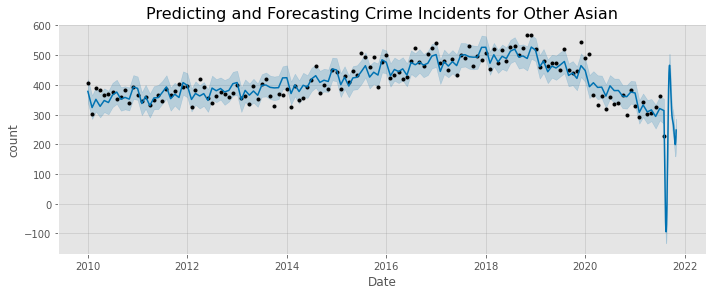

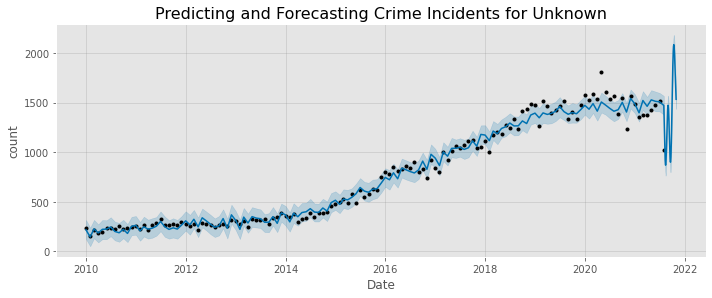

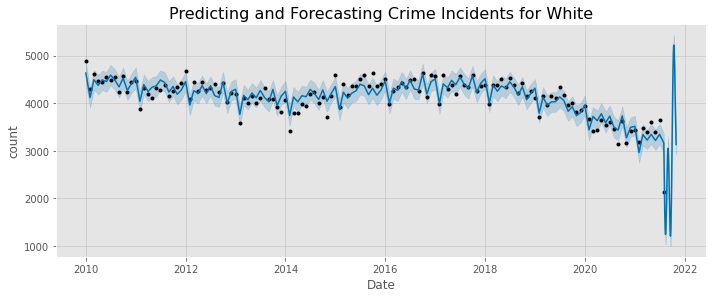

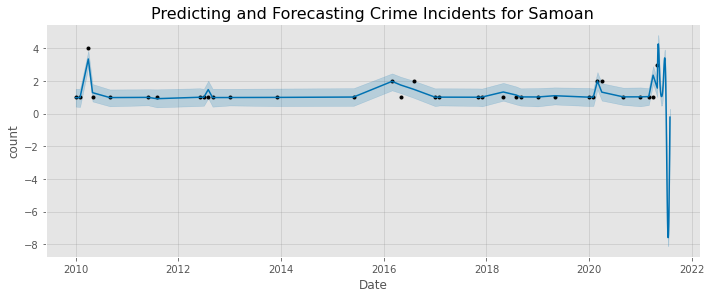

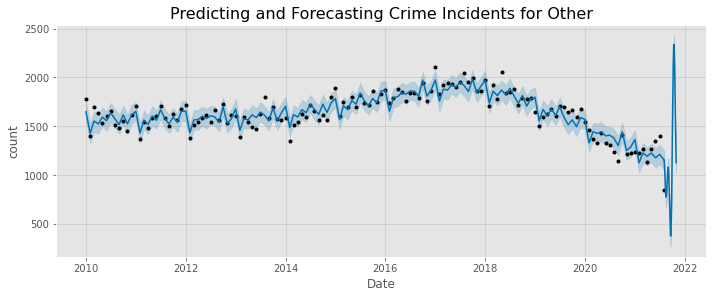

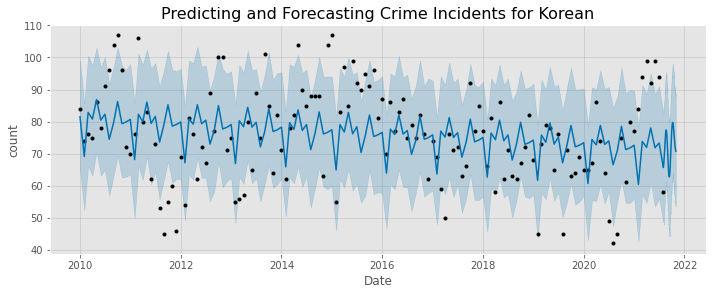

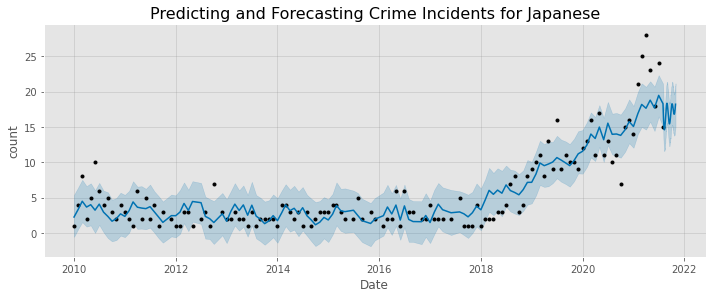

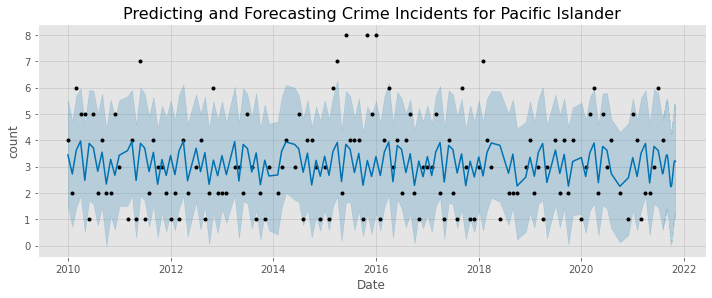

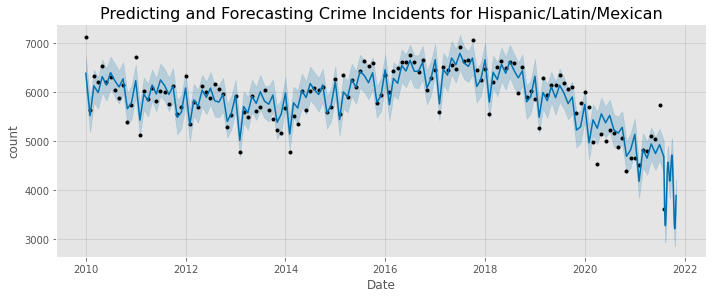

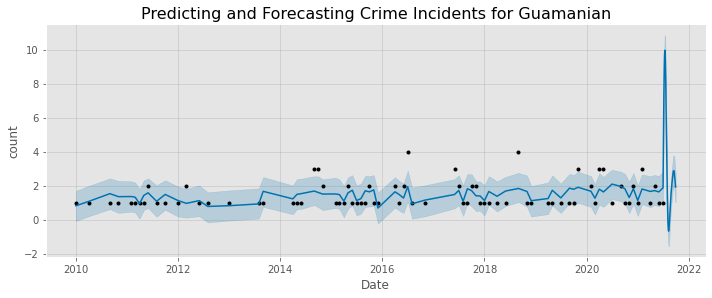

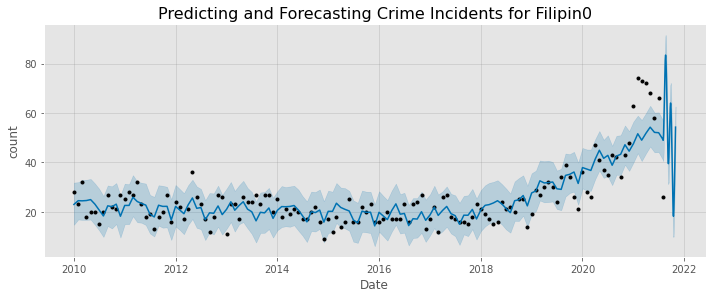

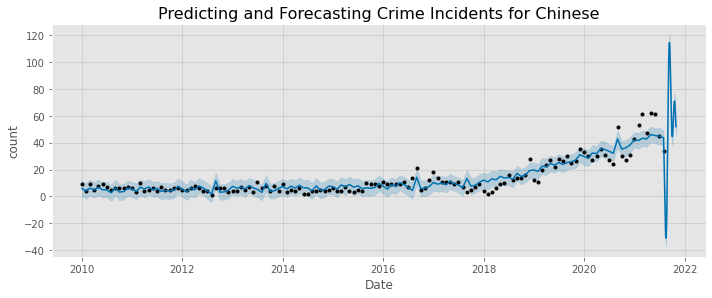

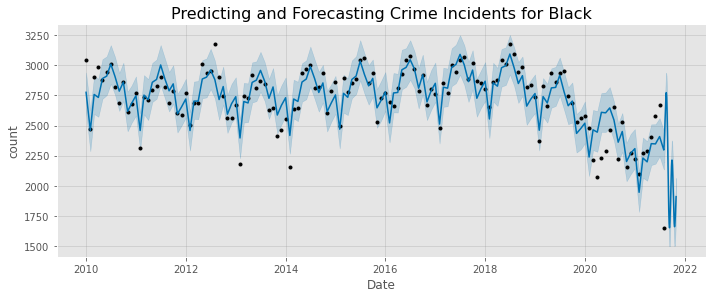

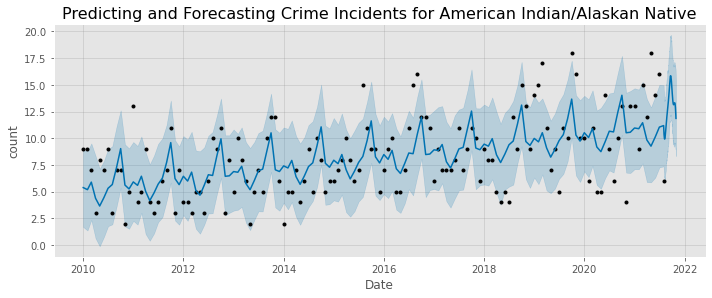

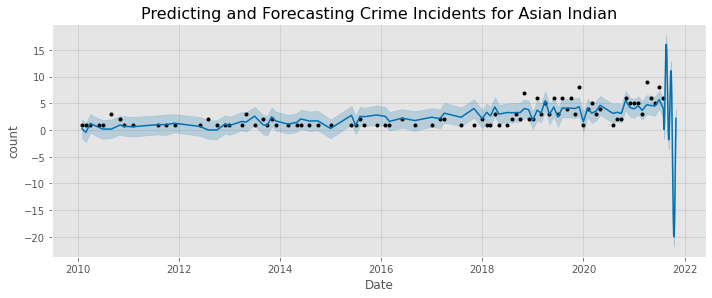

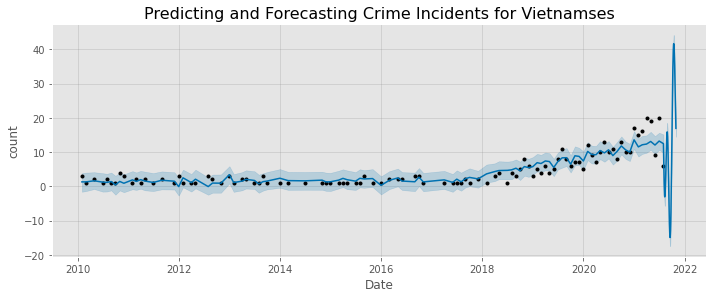

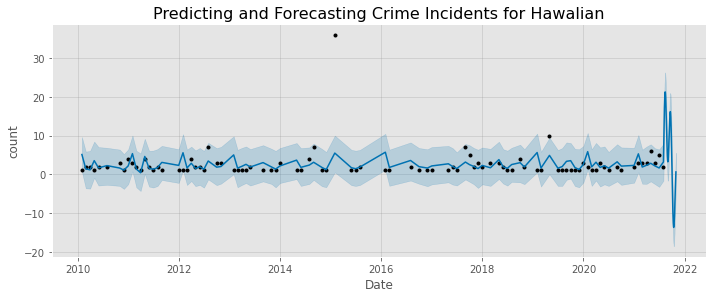

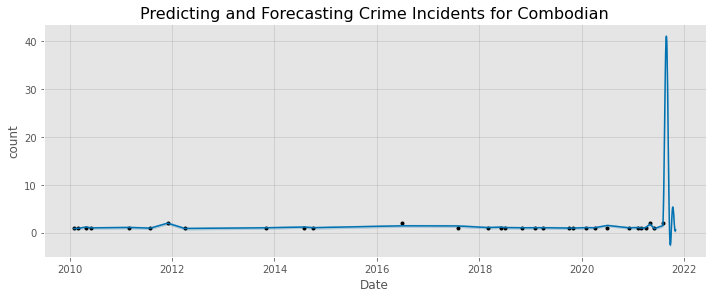

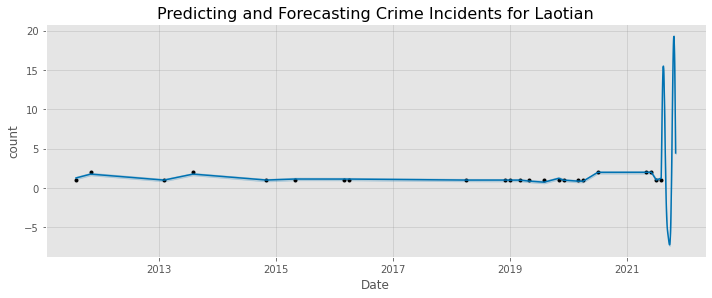

In [17]:
Forecast = {}
for victimdescent in list(train_data['Victim Descent'].unique()):
  result = Predictions(victimdescent)
  Forecast[victimdescent] = result

### Error Analysis
we will evauate the forecast that we performed above.

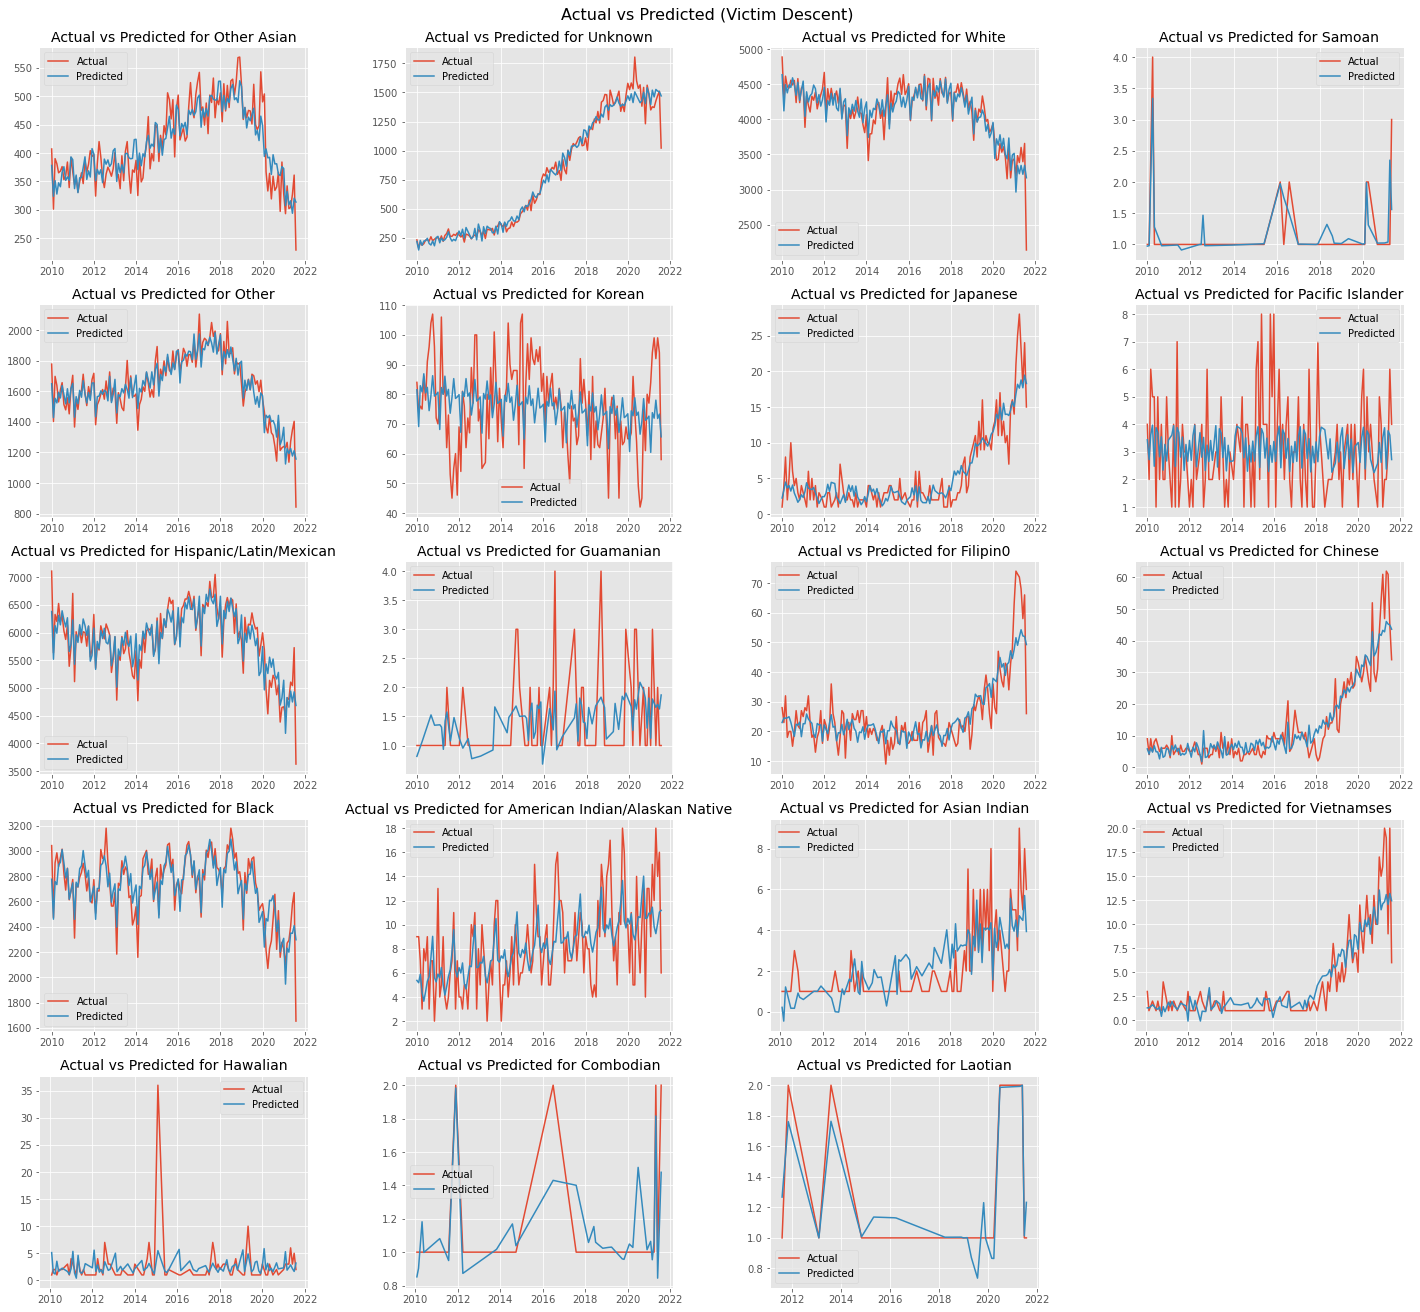

In [40]:
MAE_Score = {}
RMSE_scores = {}
SMAPE_score= {}
count = 1
plt.figure(figsize=(20,18))
plt.suptitle('Actual vs Predicted (Victim Descent)',fontsize=16, y=1.01)
for i in list(train_data['Victim Descent'].unique()):
  plt.subplot(5,4,count)
  df1 = train_data[train_data['Victim Descent']==i] .reset_index(drop=True)
  actual = df1['y']
  date = list(df1.ds)
  df2 = Forecast[i]
  pred = df2.iloc[:df1.shape[0],-1]
  mae = mean_absolute_error(actual,pred)
  MAE_Score[i] = mae
  RMSE_scores[i] = rmse(pred,actual)
  SMAPE_score[i] = smape(pred,actual)
  plt.plot(date,actual, label='Actual')
  plt.plot(date,pred, label='Predicted')
  plt.title('Actual vs Predicted for '+i, fontsize=14)
  plt.legend()
  count += 1
plt.tight_layout()
plt.show()

In [27]:
MAE_Score

{'American Indian/Alaskan Native': 2.3333486621176065,
 'Asian Indian': 1.0736128901783062,
 'Black': 88.88968198538012,
 'Chinese': 3.248845718222505,
 'Combodian': 0.1280520713086714,
 'Filipin0': 4.689740928358687,
 'Guamanian': 0.5370844564648479,
 'Hawalian': 1.6649858791292802,
 'Hispanic/Latin/Mexican': 193.41521821954288,
 'Japanese': 1.7404266194716747,
 'Korean': 11.004830063618027,
 'Laotian': 0.10108884945510382,
 'Other': 57.9647161261612,
 'Other Asian': 23.60585269460959,
 'Pacific Islander': 1.2908129361953686,
 'Samoan': 0.20330458584285807,
 'Unknown': 50.158305379957895,
 'Vietnamses': 1.406411551046212,
 'White': 120.7668966122017}

In [28]:
RMSE_scores

{'American Indian/Alaskan Native': 2.913574101627007,
 'Asian Indian': 1.3875467955133056,
 'Black': 126.76150213928275,
 'Chinese': 4.5874017165467755,
 'Combodian': 0.2003077082424769,
 'Filipin0': 6.41479695393039,
 'Guamanian': 0.6965596978569455,
 'Hawalian': 3.654839907286112,
 'Hispanic/Latin/Mexican': 259.39208057536865,
 'Japanese': 2.333726592656261,
 'Korean': 13.807820264683643,
 'Laotian': 0.14254622415667637,
 'Other': 76.47930628544087,
 'Other Asian': 30.694827968093133,
 'Pacific Islander': 1.635210680390075,
 'Samoan': 0.41646700068477166,
 'Unknown': 74.26148360871115,
 'Vietnamses': 2.035884797974802,
 'White': 165.32889254320844}

In [29]:
SMAPE_score

{'American Indian/Alaskan Native': 30.101782058100014,
 'Asian Indian': 52.23890127372469,
 'Black': 3.426970494894848,
 'Chinese': 32.443264067344565,
 'Combodian': 10.431716729479538,
 'Filipin0': 18.457289642825472,
 'Guamanian': 34.04475737466623,
 'Hawalian': 55.44405453072715,
 'Hispanic/Latin/Mexican': 3.426790565746948,
 'Japanese': 42.04924589731244,
 'Korean': 14.806768650934561,
 'Laotian': 8.93641464154368,
 'Other': 3.766056283333372,
 'Other Asian': 5.8648727511966054,
 'Pacific Islander': 43.40967705838737,
 'Samoan': 12.549085278940161,
 'Unknown': 7.647224089903187,
 'Vietnamses': 42.18322502842412,
 'White': 3.0841497005000953}

In [39]:
smape_scores = []
for i in list(vict_descent['Victim Descent'].unique()):
  smape_scores.append(SMAPE_score[i])
print('mean SMAPE score:',np.mean(smape_scores))

mean SMAPE score: 22.332223479893955


From the scores and figures above we can see that forecast/prediction for some of the victim descent is poor. Not all the descent shows same seasonality so we need to do more analysis to correct them.